# Introduction 

*This notebook aims to: Apply what you learned from the book "Build a Large Language Model (From Scratch)" in one place and I will collect what you learned from the book and some important notes that enable you to understand and build large language models.*

In [6]:

@dataclass
class CustomArguments:
    model_name: str = "meta-llama/Meta-Llama-3-8B"
    dataset: str = "tatsu-lab/alpaca"
    max_seq_length: int = 512
    use_liger: bool = False
    Paths = {
    'data':r"data\the-verdict.txt",
    'config_model':r"congif_gpt_124m.json"
    }

CustomArguments.Paths

{'data': 'data\\the-verdict.txt', 'config_model': 'congif_gpt_124m.json'}

##  What is an LLM?
> An LLM, a large language model, is a neural network designed to
understand, generate, and respond to human-like text. These models are deep
neural networks trained on massive amounts of text data, sometimes
encompassing large portions of the entire publicly available text on the
internet.

> The **"large"** in large language model refers to both the model's size in terms
of parameters and the immense dataset on which it's trained. Models like this
often have tens or even hundreds of billions of parameters, which are the
adjustable weights in the network that are optimized during training to predict
the next word in a sequence. Next-word prediction is sensible because it
harnesses the inherent sequential nature of language to train models on
understanding context, structure, and relationships within text.


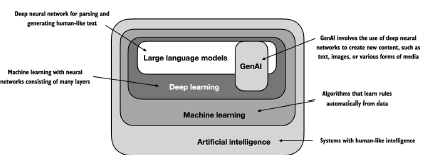

## Building a large language model
> In this Notebooke ,you can laid the groundwork for understanding LLMs. from the
book *"Build a Large Language Model (From Scratch)"* , you  can coding one from scratch. We will take the fundamental idea behind GPT as a blueprint and tackle this in three stages, as
outlined in Figure 


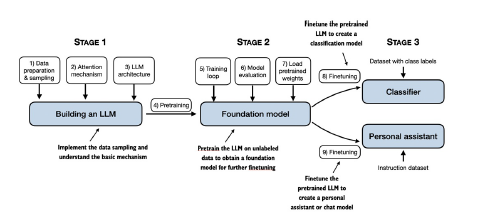


:link: You can access all the steps through :<br>
- **my repo** :<br>
- or the **official repo** of the book :
<br>

Now let's get started, away from the theoretical words in the book and considering that all the codes, classes and functions are ready to use together.

# Setup Environment

In [3]:
# Import Libraries and Classes
import pandas as pd 
import torch
from torch import nn 
import UtilsFunctions  as uf
from DataUtils  import llm_dataloader
import tiktoken as ttk
import TransformerBlocks as transformer 

In [16]:
class cVariables(object):
  # make singelton Class 
  __shared_instance = None
  @staticmethod
  def get_instance():
    if cVariables.__shared_instance == None: cVariables()
    return __shared_instance # type: ignore

  def __init__(self):
    if cVariables.__shared_instance != None : raise Exception("This class is a singleton class !")
    else:  cVariables.__shared_instance = self
  
  Paths = {
    'data':r"data\the-verdict.txt",
    'config_model':r"congif_gpt_124m.json"
  }
  
  GPT_CONFIG_128M = uf.read_json(Paths['config_model'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  ProcessData ={
    'max_length': GPT_CONFIG_128M['context_length'],
    'batch_size': 64,
    'stride' : GPT_CONFIG_128M['context_length']//2
  }



In [17]:
#  instance of classes
tokenizer  = ttk.get_encoding("gpt2") 
var = cVariables()
torch.manual_seed(123)

# Load and Process Data

In [18]:
data_raw = uf.read_txt(var.Paths['data'])
total_token = len(tokenizer.encode(data_raw))
print(f"-> Number of Characters : {len(data_raw)}\n-> Number of Tokens : {total_token}")

-> Number of Characters : 20479
-> Number of Tokens : 5145


In [24]:
# Split the data into training and Validation
train_ratio = 0.90
split_idxs = int(train_ratio * len(data_raw))
train_data = data_raw[:split_idxs]
val_data = data_raw[split_idxs:]
print(f'-> Length of training data : {len(train_data)}\n-> Length of val_data : {len(val_data)}')
# Sanity check

if total_token * (train_ratio) < var.GPT_CONFIG_128M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_token * (1-train_ratio) < var.GPT_CONFIG_128M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

-> Length of training data : 18431
-> Length of val_data : 2048


In [25]:
train_dataloader = llm_dataloader(
  txt= train_data,
  tokenizer = tokenizer,
  max_length = var.ProcessData['max_length'],
  batch_size = var.ProcessData['batch_size'],
  stride = var.ProcessData["stride"],
  shuffle=False,
  drop_last = False
)
dataiter = iter(train_dataloader)
firstbatch =next(dataiter)
print(f'inputs: \n{firstbatch[0]} \ntarget: \n{firstbatch[1]}')
firstbatch[0].shape

100%|██████████| 35/35 [00:00<00:00, 5835.38it/s]

inputs: 
tensor([[   40,   367,  2885,  ...,   198,  5779, 28112],
        [  286,   616,  4286,  ...,   470,   910,   416],
        [10197,   832,   262,  ...,  9074,    13,   402],
        ...,
        [  286,  1762,    30,  ...,   388,   351,   262],
        [ 2951,   319,   262,  ...,  1194, 14000,    13],
        [ 1459,   714,  1239,  ...,  1517,   484,  1444]]) 
target: 
tensor([[  367,  2885,  1464,  ...,  5779, 28112, 10197],
        [  616,  4286,   705,  ...,   910,   416,  4150],
        [  832,   262, 46475,  ...,    13,   402,   271],
        ...,
        [ 1762,    30,  2011,  ...,   351,   262,  1459],
        [  319,   262,  1327,  ..., 14000,    13,   383],
        [  714,  1239,   423,  ...,   484,  1444,   616]])


torch.Size([35, 256])

In [26]:
val_dataloader = llm_dataloader(
  txt= val_data,
  tokenizer = tokenizer,
  max_length = var.ProcessData['max_length'],
  batch_size = var.ProcessData['batch_size'],
  stride = var.ProcessData["stride"],
  shuffle=False,
  drop_last = False
)
dataiter = iter(val_dataloader)
firstbatch =next(dataiter)
firstbatch[0].shape

100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]


torch.Size([3, 256])

# Build GPT model 

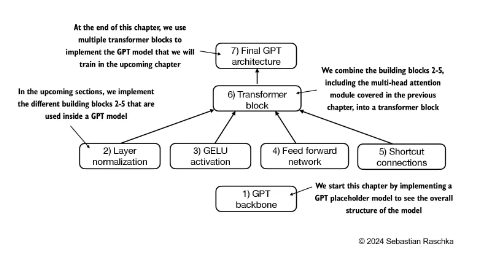

**Normalizing activations with layer normalization**
* Layer normalization, also known as LayerNorm (Ba et al. 2016), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
* This stabilizes training and enables faster convergence to effective weights
* Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layear

<hr>

**Feed forward network with GELU activations**
* In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
We start with the activation function
* In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
* In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
* GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU
* GELU (Hendrycks and Gimpel 2016) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
In practice, it's common to implement a computationally cheaper approximation: 

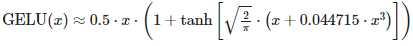

 (the original GPT-2 model was also trained with this approximation)
<hr>

**Adding shortcut connections**
* Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
* Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
* A shortcut connection creates an alternative shorter path for the gradient to flow through the network
* This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between


## Transformer 

**Connecting attention and linear layers in a transformer block**
* In this section, we now combine the previous concepts into a so-called transformer block
* A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
* In addition, the transformer block also uses dropout and shortcut connections


In [ ]:
# First we will build Transformer architecture
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = transformer.MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = transformer.FeedForwardGELU(cfg)
        self.norm1 = transformer.LayerNorm(cfg["emb_dim"])
        self.norm2 = transformer.LayerNorm(cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        resid_conn = x
        x = self.norm1(x)  # pre-LayerNorm
        x = self.attn(x)
        x = self.dropout(x)
        x = x + resid_conn

        resid_conn = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + resid_conn
        return x

## GPT 

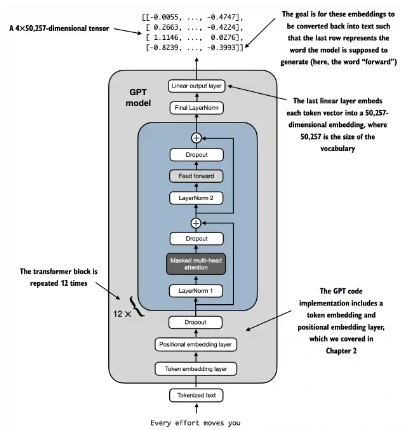

```pathon
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias}
```

> GPT2-small (the 124M configuration we already implemented):
> * "emb_dim" = 768
> * "n_layers" = 12
> * "n_heads" = 12

>   GPT2-medium:
> * "emb_dim" = 1024
> * "n_layers" = 24
> * "n_heads" = 16

> GPT2-large:
> * "emb_dim" = 1280
> * "n_layers" = 36
> * "n_heads" = 20

>  GPT2-XL:
> * "emb_dim" = 1600
> * "n_layers" = 48
> * "n_heads" = 25

In [ ]:
# then build the GPT Architecture based on your Config
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.dropout_emb = nn.Dropout(cfg["drop_rate"])
    self.transformer_blocks = nn.Sequential( *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = transformer.LayerNorm(cfg["emb_dim"])
    self.out_ff = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias = False)
  
  def forward(self, idx):
    batch_size, seq_len = idx.shape
    tok_embeds = self.tok_emb(idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=idx.device))

    x = tok_embeds + pos_embeds
    x = self.dropout_emb(x)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_ff(x)
    return logits


# Train and Evaluate Model

# Test Model

# Saving and Load Model weights

# Conclution